# HW3


##Updated Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


params = {'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'axes.titlesize' : 18,
          'axes.labelsize' : 16,
          'legend.fontsize': 14,
          'legend.title_fontsize': 18,
          'figure.titlesize': 20,
          'figure.figsize': (8, 6) }

pylab.rcParams.update(params)

# get the new data set
print("Please load  HW3_data.csv csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]
dataset = pd.read_csv(filename)
raw_trainingSet, raw_testSet = model_selection.train_test_split(dataset, train_size=0.8, test_size=0.2, random_state=95)



def prepare_data(training_data, new_data):
  # Create a copy of the new data to transform
  prepared_data = new_data.copy()

  # Replace missing values in 'household_income' with the median of the training data
  median_household_income = training_data['household_income'].median()
  prepared_data['household_income'].fillna(median_household_income, inplace=True)

  # Check if the 'blood_type' column is present
  if 'blood_type' in prepared_data.columns:
    # Create the 'SpecialProperty' feature before dropping 'blood_type'
    prepared_data['SpecialProperty'] = prepared_data['blood_type'].isin(['O+', 'B+'])
    prepared_data.drop(columns=['blood_type'], inplace=True)

  min_max_pcr_features = ['PCR_03', 'PCR_10']
  standard_pcr_features = ['PCR_01', 'PCR_02', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09']

  # Min-Max normalization for PCR_03 and PCR_10
  scaler1 = MinMaxScaler(feature_range=(-1, 1))
  scaler1.fit(training_data[min_max_pcr_features])
  prepared_data[min_max_pcr_features] = scaler1.transform(prepared_data[min_max_pcr_features])

  # Standardization for the other PCR features
  scaler2 = StandardScaler()
  scaler2.fit(training_data[standard_pcr_features])
  prepared_data[standard_pcr_features] = scaler2.transform(prepared_data[standard_pcr_features])

  return prepared_data

"""

# Prepare training set according to itself
trainingSet = prepare_data(raw_trainingSet, raw_trainingSet)

# Prepare test set according to the raw training set
testSet = prepare_data(raw_trainingSet, raw_testSet)

trainingSet.to_csv("PreparedTrainingSet.csv", index=False)
testSet.to_csv("PreparedTestSet.csv", index=False)
"""

Please load  HW3_data.csv csv data


Saving data_HW3.csv to data_HW3.csv


'\n\n# Prepare training set according to itself\ntrainingSet = prepare_data(raw_trainingSet, raw_trainingSet)\n\n# Prepare test set according to the raw training set\ntestSet = prepare_data(raw_trainingSet, raw_testSet)\n\ntrainingSet.to_csv("PreparedTrainingSet.csv", index=False)\ntestSet.to_csv("PreparedTestSet.csv", index=False)\n'

In [2]:
#loading the preprocessed training and test sets
!rm *.csv

from google.colab import files
print("Please load PreparedTrainingSet.csv")
uploadedData = files.upload()
filename = list(uploadedData)[0]
training_dataset = pd.read_csv(filename)

print("Please load PreparedTestSet.csv")
uploadedData = files.upload()
filename = list(uploadedData)[0]
test_dataset = pd.read_csv(filename)

Please load PreparedTrainingSet.csv


Saving PreparedTrainingSet.csv to PreparedTrainingSet.csv
Please load PreparedTestSet.csv


Saving PreparedTestSet.csv to PreparedTestSet.csv


##Q2

**Linear Regressor**

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
      """
      Custom linear regression model
      """
      def __init__(self, lr: float = 1e-5):
          """
          Initialize an instance of this class.
          ** Do not edit this method **

          :param lr: the SGD learning rate (step size)
          """
          self.lr = lr
          self.batch_size = 32
          self.w = None
          self.b = 0.0

      # Initialize a random weight vector
      def init_solution(self, n_features: int):
          """
          Randomize an initial solution (weight vector)
          ** Do not edit this method **

          :param n_features:
          """
          self.w = np.zeros(n_features)
          self.b = 0.0

      @staticmethod
      def loss(w, b: float, X, y):
          """
          Compute the MSE objective loss.

          :param w: weight vector for linear regression; array of shape (n_features,)
          :param b: bias scalar for linear regression
          :param X: samples for loss computation; array of shape (n_samples, n_features)
          :param y: targets for loss computation; array of shape (n_samples,)
          :return: the linear regression objective loss (float scalar)
          """

          # Compute predictions
          predictions = X.dot(w) + b

          # Compute the MSE loss
          loss = np.mean((predictions - y) ** 2)
          return loss

      @staticmethod
      def gradient(w, b: float, X, y):
          """
          Compute the (analytical) linear regression objective gradient.

          :param w: weight vector for linear regression; array of shape (n_features,)
          :param b: bias scalar for linear regression
          :param X: samples for loss computation; array of shape (n_samples, n_features)
          :param y: targets for loss computation; array of shape (n_samples,)
          :return: a tuple with (the gradient of the weights, the gradient of the bias)
          """
          # Number of samples
          m = X.shape[0]

          # Compute predictions
          predictions = X.dot(w) + b

          # Compute the error
          errors = predictions - y

          # Gradient with respect to w
          g_w = (2 / m) * X.T.dot(errors)

          # Gradient with respect to b
          g_b = (2 / m) * np.sum(errors)

          return g_w, g_b

      def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                        X_val  =None, y_val = None):
          """
          Fit the model according to the given training data.

          :param X: training samples; array of shape (n_samples, n_features)
          :param y: training targets; array of shape (n_samples,)
          :param max_iter: number of SGD iterations
          :param keep_losses: should compute the train & val losses during training?
          :param X_val: validation samples to compute the loss for (for logs only)
          :param y_val: validation labels to compute the loss for (for logs only)
          :return: training and validation losses during training
          """
          # Initialize learned parameters
          self.init_solution(X.shape[1])

          train_losses = []
          val_losses = []

          if keep_losses:
              train_losses.append(self.loss(self.w, self.b, X, y))
              val_losses.append(self.loss(self.w, self.b, X_val, y_val))

          # Iterate over batches (SGD)
          for itr in range(0, max_iter):
              start_idx = (itr * self.batch_size) % X.shape[0]
              end_idx = min(X.shape[0], start_idx + self.batch_size)
              batch_X = X[start_idx: end_idx]
              batch_y = y[start_idx: end_idx]

              # Compute the gradient for the current *batch*
              g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

              # Perform a gradient step
              self.w -= self.lr * g_w
              self.b -= self.lr * g_b

              if keep_losses:
                  train_losses.append(self.loss(self.w, self.b,  X, y))
                  val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

          return train_losses, val_losses

      def fit(self, X, y, max_iter: int = 1000):
          """
          Fit the model according to the given training data.
          ** Do not edit this method **

          :param X: training samples; array of shape (n_samples, n_features)
          :param y: training targets; array of shape (n_samples,)
          :param max_iter: number of SGD iterations
          """
          self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

          return self

      def predict(self, X):
          """
          Regress labels on samples in X.

          :param X: samples for prediction; array of shape (n_samples, n_features)
          :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
          """

          # Compute prediction
          y_pred = X.dot(self.w) + self.b

          return y_pred

**VERIFY GRADIENT**

In [4]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=18, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=14)
    axs[1].set_xlabel('$\delta_b$', fontsize=14)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=14)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=14)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


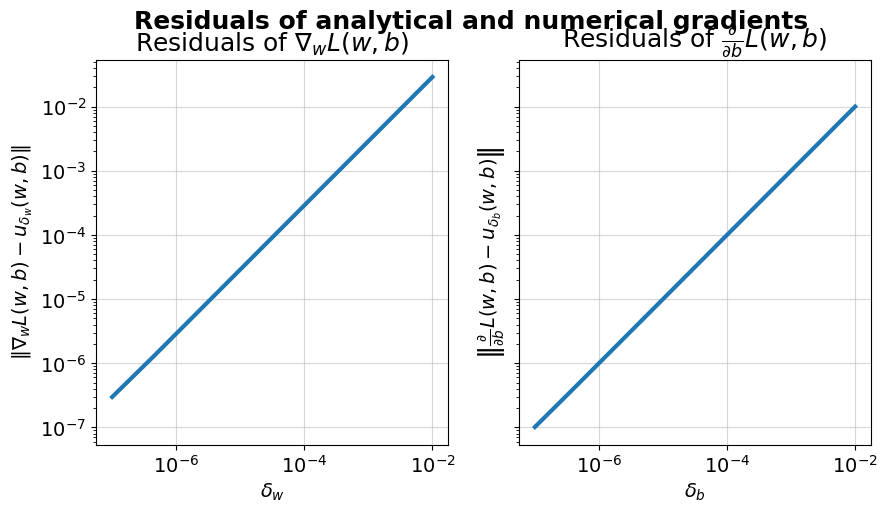

In [5]:
# compares the numerical gradients to the analytical ones (based one the new training set)
newTrainingSet = training_dataset
pcr_columns = [col for col in newTrainingSet.columns if col.startswith('PCR_')]
X = newTrainingSet[pcr_columns]
y = newTrainingSet['contamination_level']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=95)
compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))



##Q3

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 0.07481921098536524, Best validation loss = 0.09036979523092965
lr size = 1e-08, Best train loss = 0.07481630622574002, Best validation loss = 0.09036671829250281
lr size = 1e-07, Best train loss = 0.07478726734327115, Best validation loss = 0.09033595778120664
lr size = 1e-06, Best train loss = 0.07449774812186245, Best validation loss = 0.09002923819593164
lr size = 1e-05, Best train loss = 0.07168776832574221, Best validation loss = 0.08704885228634808
lr size = 0.0001, Best train loss = 0.05060198230483696, Best validation loss = 0.0644202970611741
lr size = 0.001, Best train loss = 0.02115260049595843, Best validation loss = 0.02947791526898647
lr size = 0.01, Best train loss = 0.02097961181489805, Best validation loss = 0.028549757366151632
lr size = 0.1, Best train loss = 0.021210371929640117, Best validation loss = 0.027793297701377683


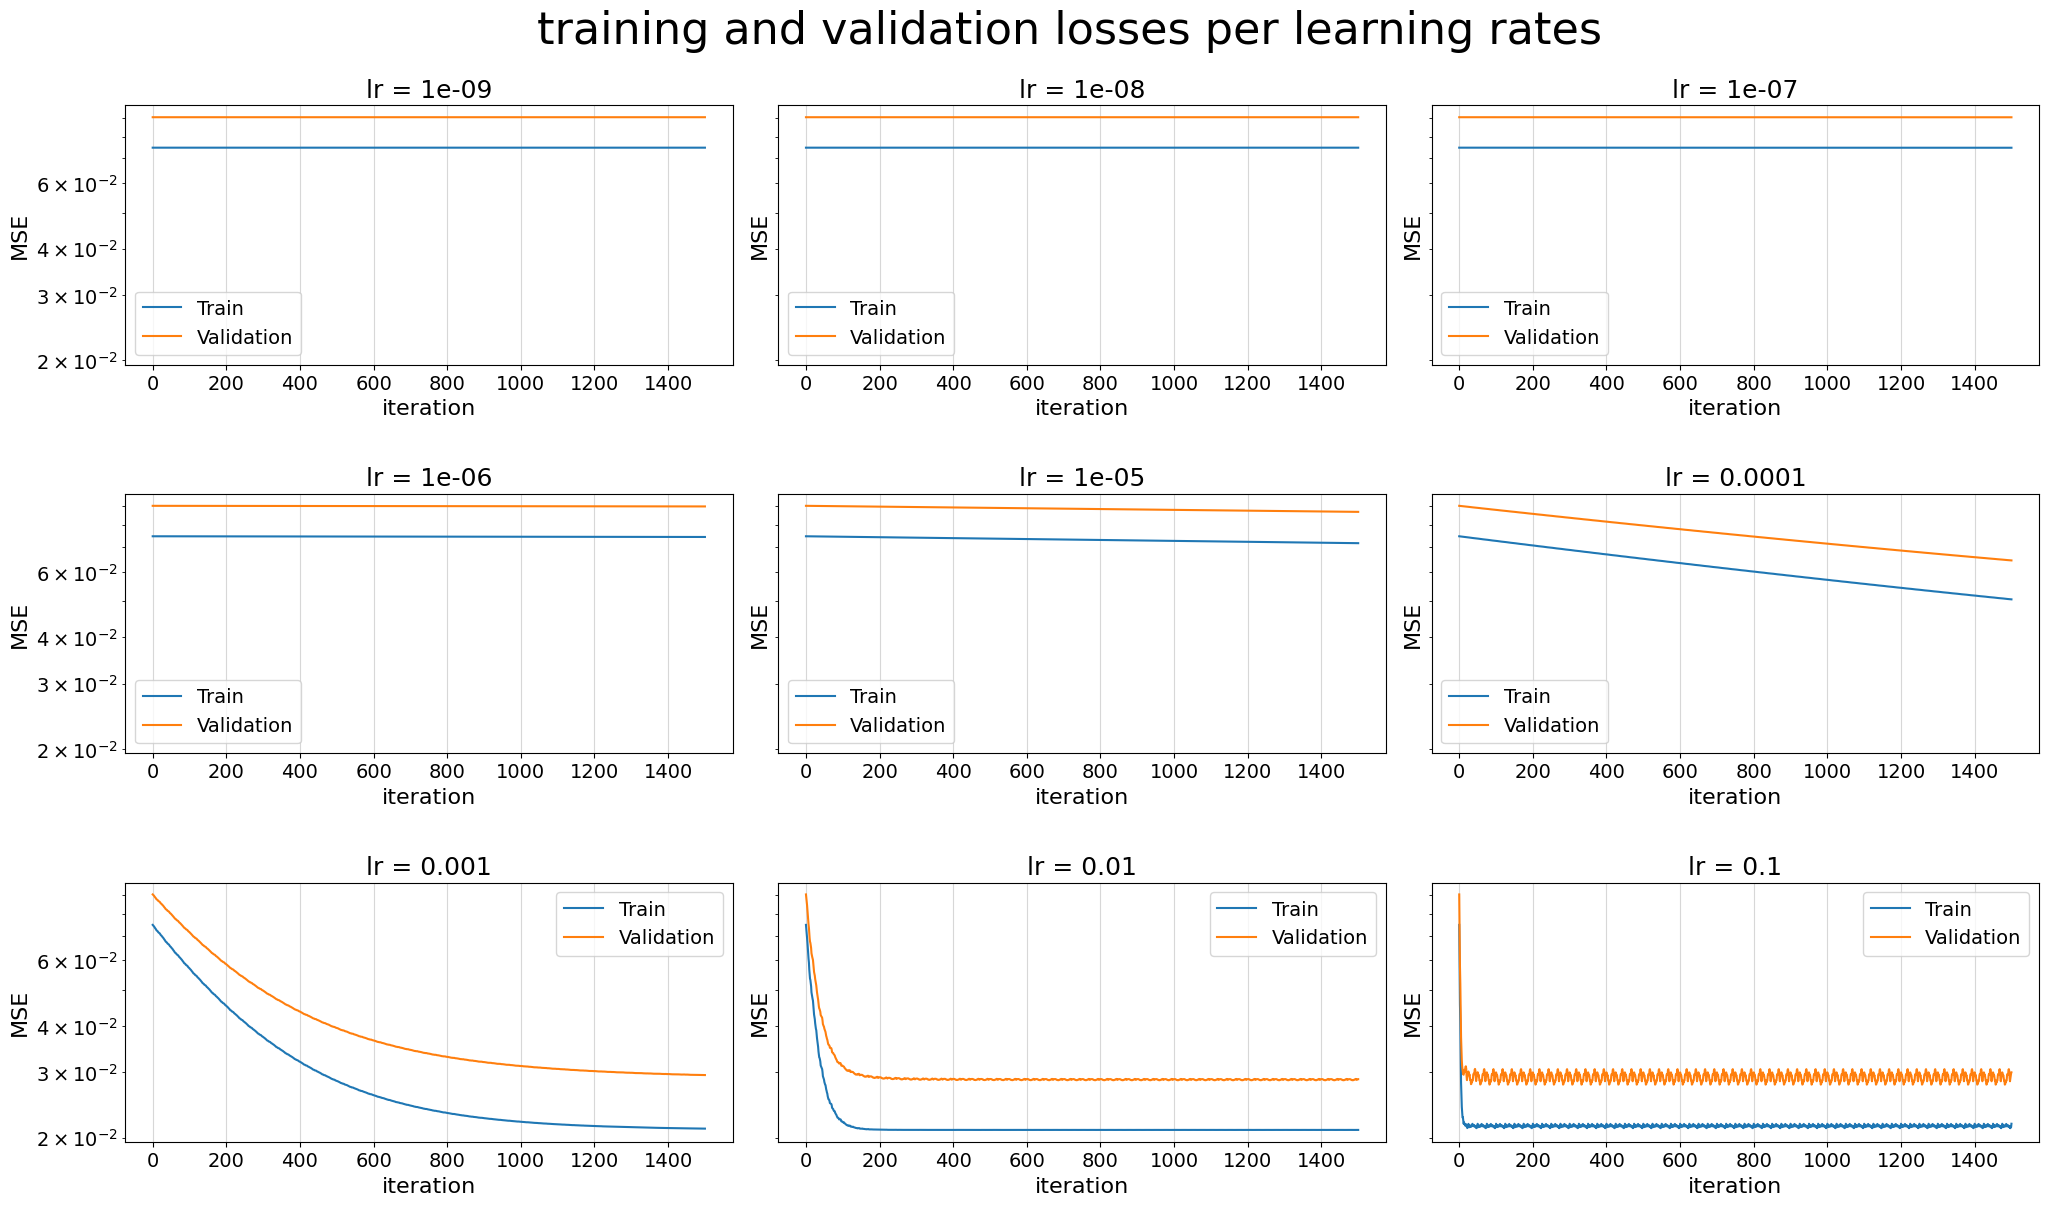

In [7]:
test_lr(X_train, y_train, X_val, y_val, "training and validation losses per learning rates")

##Q4

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor

# prepare data and using 5-fold validation with a dummy regressor
X_train = X
Y_train = y
dummyRegressor = DummyRegressor(strategy='mean')
cv_results = cross_validate(dummyRegressor, X_train, Y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
print(f"Training accuracy: {-np.mean(cv_results['train_score'])}")
print(f"Validation accuracy: {-np.mean(cv_results['test_score'])}")



Training accuracy: 0.06788300857640847
Validation accuracy: 0.06814155632688337


In [9]:
# Retrain a dummy regressor on the entire training set
dummyRegressor_section_6 = DummyRegressor(strategy='mean')
dummyRegressor_section_6.fit(X_train, Y_train)

DummyRegressor()

##Q5

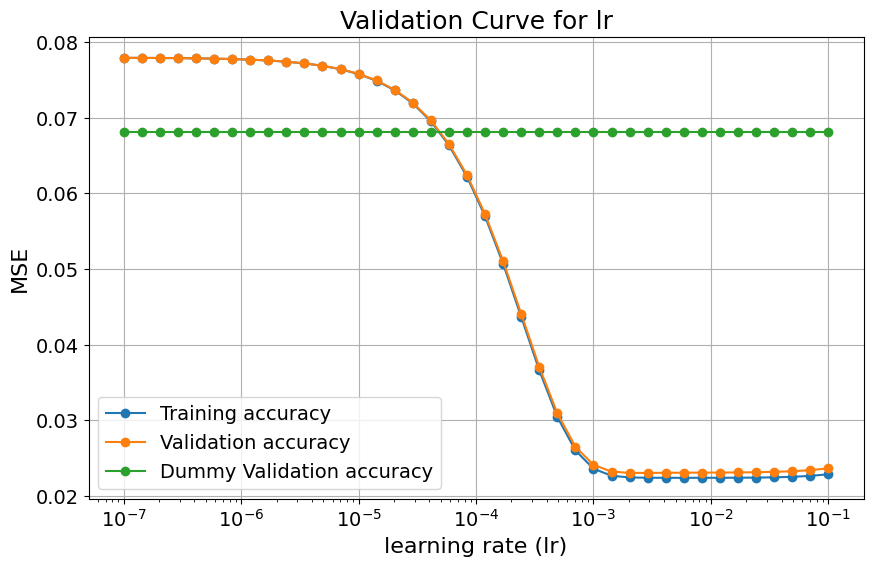

Best lr: 0.0028942661247167516
Average training loss for best lr: 0.0224
Average validation loss for best lr: 0.0230


In [10]:
# performing lr tuning with 5-fold cross validation on our LinearRegressor model. Ploting the Training and Validation accuracies for each lr value
lr_values = np.logspace(-7, -1, 40)
train_scores = []
validation_scores = []
dummy_validation_scores = []

for lr in lr_values:
  linearRegressor = LinearRegressor(lr)
  cv_results = cross_validate(linearRegressor, X_train, Y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  train_scores.append(-np.mean(cv_results['train_score']))
  validation_scores.append(-np.mean(cv_results['test_score']))
  cv_results = cross_validate(dummyRegressor, X_train, Y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  dummy_validation_scores.append(-np.mean(cv_results['test_score']))

train_scores = np.array(train_scores)
validation_scores = np.array(validation_scores)

plt.figure(figsize=(10, 6))
plt.semilogx(lr_values, train_scores, label='Training accuracy', marker='o')
plt.semilogx(lr_values, validation_scores, label='Validation accuracy', marker='o')
plt.semilogx(lr_values, dummy_validation_scores, label='Dummy Validation accuracy', marker='o')
plt.xlabel('learning rate (lr)')
plt.ylabel('MSE')
plt.title('Validation Curve for lr')
plt.legend()
plt.grid(True)
plt.show()

# finding best lr
best_lr_index = np.argmin(validation_scores)
best_lr = lr_values[best_lr_index]
best_lr_train_score = train_scores[best_lr_index]
best_lr_validation_score = validation_scores[best_lr_index]

print(f"Best lr: {best_lr}")
print(f"Average training loss for best lr: {best_lr_train_score:.4f}")
print(f"Average validation loss for best lr: {best_lr_validation_score:.4f}")



In [11]:
# training and validating LinearRegressor with the best lr achieved before
bestLinearReggressor = LinearRegressor(best_lr)
cv_results = cross_validate(bestLinearReggressor, X_train, Y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
print(f"Training accuracy: {-np.mean(cv_results['train_score'])}")
print(f"Validation accuracy: {-np.mean(cv_results['test_score'])}")

Training accuracy: 0.022388015133043556
Validation accuracy: 0.023025409280064683


In [12]:
# Retrain a linear regressor on the entire training set according the the best lr
linearRegressor_section_6 = LinearRegressor(best_lr)
linearRegressor_section_6.fit(X_train, Y_train)

LinearRegressor(lr=0.0028942661247167516)

##Q7

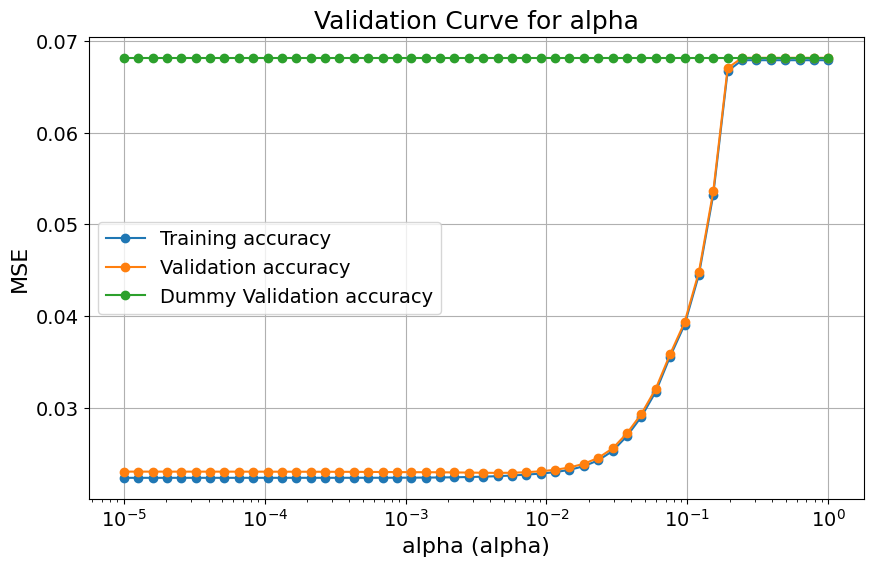

Best alpha: 0.004498432668969444
Average training loss for best alpha: 0.0226
Average validation loss for best alpha: 0.0229


In [13]:
from sklearn.linear_model import Lasso

# performing alpha tuning with 5-fold cross validation on our LassoRegressor model. Ploting the Training and Validation accuracies for each alpha value
alpha_values = np.logspace(-5, 0, 50)
train_scores = []
validation_scores = []
dummy_validation_scores = []

for alpha in alpha_values:
  lassoRegressor = Lasso(alpha=alpha, fit_intercept=True)
  cv_results = cross_validate(lassoRegressor, X_train, Y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  train_scores.append(-np.mean(cv_results['train_score']))
  validation_scores.append(-np.mean(cv_results['test_score']))
  cv_results = cross_validate(dummyRegressor, X_train, Y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  dummy_validation_scores.append(-np.mean(cv_results['test_score']))

train_scores = np.array(train_scores)
validation_scores = np.array(validation_scores)

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, train_scores, label='Training accuracy', marker='o')
plt.semilogx(alpha_values, validation_scores, label='Validation accuracy', marker='o')
plt.semilogx(alpha_values, dummy_validation_scores, label='Dummy Validation accuracy', marker='o')
plt.xlabel('alpha (alpha)')
plt.ylabel('MSE')
plt.title('Validation Curve for alpha')
plt.legend()
plt.grid(True)
plt.show()

# finding best alpha
best_alpha_index = np.argmin(validation_scores)
best_alpha = alpha_values[best_alpha_index]
best_alpha_train_score = train_scores[best_alpha_index]
best_alpha_validation_score = validation_scores[best_alpha_index]

print(f"Best alpha: {best_alpha}")
print(f"Average training loss for best alpha: {best_alpha_train_score:.4f}")
print(f"Average validation loss for best alpha: {best_alpha_validation_score:.4f}")


In [14]:
# Retrain a lasso regressor on the entire training set according the the best alpha
lassoRegressor_section_6 = Lasso(best_alpha, fit_intercept=True)
lassoRegressor_section_6.fit(X_train, Y_train)

Lasso(alpha=0.004498432668969444)

##Q9

In [15]:
# fit the Lasso model with the best alpha
lasso = Lasso(alpha=best_alpha, fit_intercept=True)
lasso.fit(X_train, Y_train)

# get the coefficients and feature names
coefficients = lasso.coef_
feature_names = X_train.columns

# create a DataFrame to hold feature names and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# find the 5 features with the largest absolute coefficients
largest_features = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(5)
print(largest_features)


  Feature  Coefficient
3  PCR_04     0.191811
1  PCR_02    -0.070741
5  PCR_06    -0.039239
7  PCR_08    -0.003756
0  PCR_01    -0.000000


##Q10

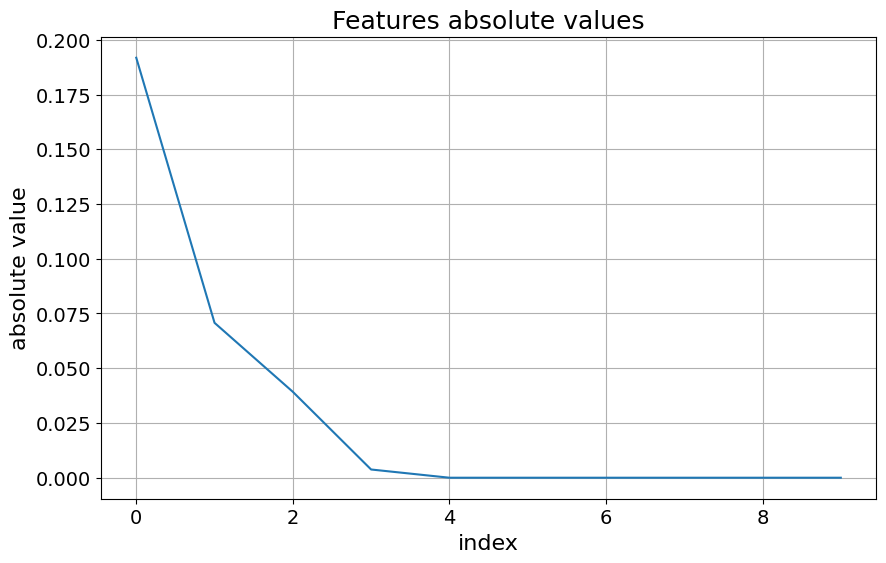

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(coefficients.shape[0]), np.flip(np.sort(np.abs(coefficients))))
plt.xlabel('index')
plt.ylabel('absolute value')
plt.title('Features absolute values')
plt.grid(True)
plt.show()

##section 4 - polynomial fitting

In [17]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(18, 5))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=22)
  plt.tight_layout()
  plt.show()

<ipython-input-17-3bda83c3783e>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


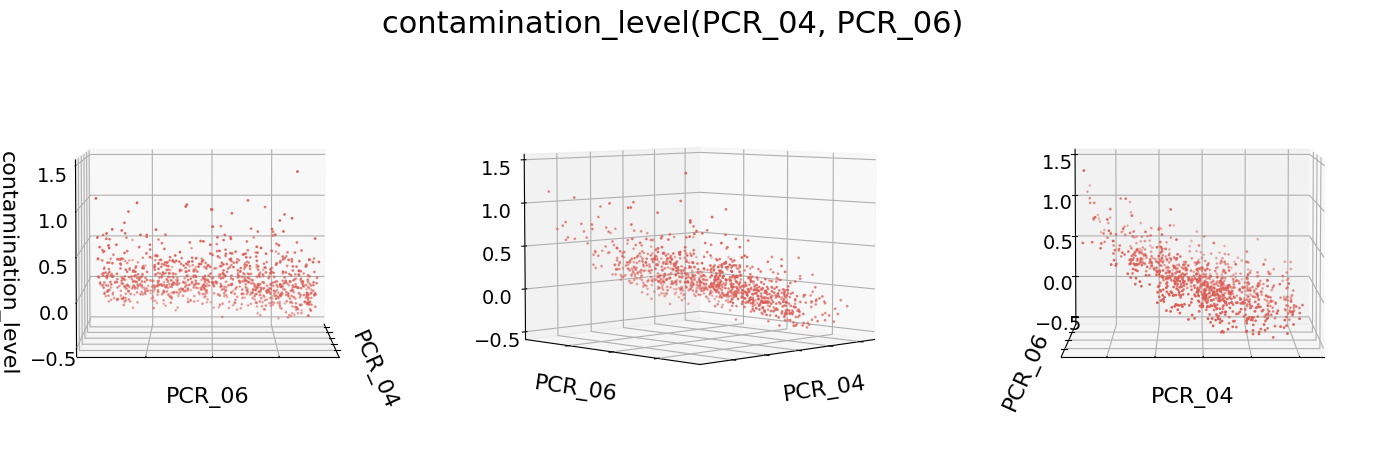

In [18]:
# Visualize the data using plot3d, i.e., plot contamination_level as a function of the PCR_04 and PCR_06 features
df_pcr_4_6 = pd.DataFrame(X_train, columns=['PCR_04', 'PCR_06'])
df_pcr_4_6['contamination_level'] = Y_train
plot3d(df_pcr_4_6, 'PCR_04', 'PCR_06', 'contamination_level', 'contamination_level(PCR_04, PCR_06)')

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# adding quadratic features for Lasso-regression model
poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(4)),
                     ('normalization', MinMaxScaler()),
                     ('Lasso', Lasso(alpha=best_alpha, fit_intercept=True))])

##Q15

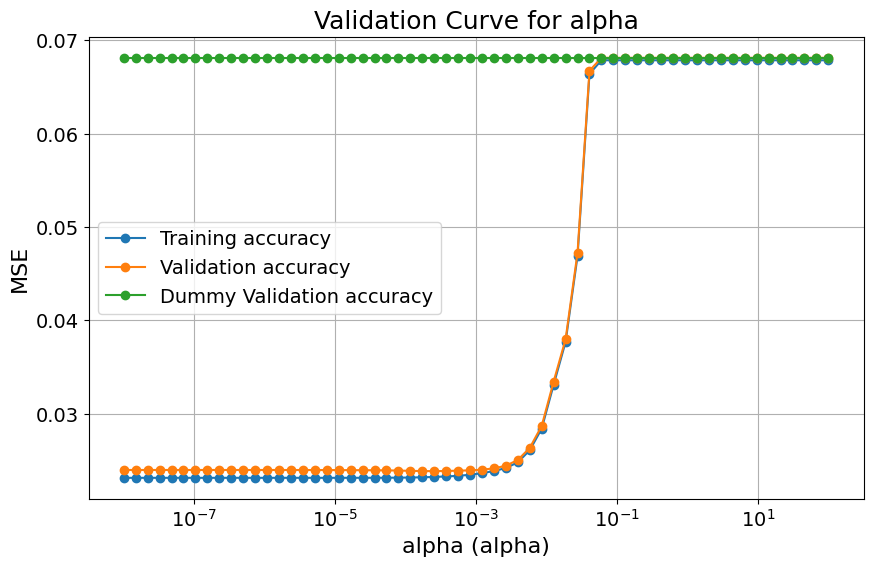

Best alpha: 0.00025514065200312873
Average training loss for best alpha: 0.0232
Average validation loss for best alpha: 0.0239


In [20]:
# performing alpha tuning with 5-fold cross validation on our LassoRegressor model with the polynomial mapping. Ploting the Training and Validation accuracies for each alpha value
alpha_values = np.logspace(-8, 2, 60)
train_scores = []
validation_scores = []
dummy_validation_scores = []

lassoRegressor = Pipeline([('feature_mapping', PolynomialFeatures(4)),
                     ('normalization', MinMaxScaler()),
                     ('Lasso', Lasso(alpha=1, fit_intercept=True))])
for alpha in alpha_values:
  lassoRegressor.set_params(Lasso__alpha=alpha)
  cv_results = cross_validate(lassoRegressor, X_train[['PCR_04', 'PCR_06']], Y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  train_scores.append(-np.mean(cv_results['train_score']))
  validation_scores.append(-np.mean(cv_results['test_score']))
  cv_results = cross_validate(dummyRegressor, X_train[['PCR_04', 'PCR_06']], Y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
  dummy_validation_scores.append(-np.mean(cv_results['test_score']))

train_scores = np.array(train_scores)
validation_scores = np.array(validation_scores)

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, train_scores, label='Training accuracy', marker='o')
plt.semilogx(alpha_values, validation_scores, label='Validation accuracy', marker='o')
plt.semilogx(alpha_values, dummy_validation_scores, label='Dummy Validation accuracy', marker='o')
plt.xlabel('alpha (alpha)')
plt.ylabel('MSE')
plt.title('Validation Curve for alpha')
plt.legend()
plt.grid(True)
plt.show()

# finding best alpha
best_alpha_index = np.argmin(validation_scores)
best_alpha = alpha_values[best_alpha_index]
best_alpha_train_score = train_scores[best_alpha_index]
best_alpha_validation_score = validation_scores[best_alpha_index]

print(f"Best alpha: {best_alpha}")
print(f"Average training loss for best alpha: {best_alpha_train_score:.4f}")
print(f"Average validation loss for best alpha: {best_alpha_validation_score:.4f}")

In [52]:
# Retrain a lasso regressor on the entire training set according the the best alpha
polynomial_lasso_section_6 = Pipeline([('feature_mapping', PolynomialFeatures(4)),
                                   ('normalization', MinMaxScaler()),
                                   ('Lasso', Lasso(alpha=best_alpha, fit_intercept=True))])
polynomial_lasso_section_6.fit(X_train[['PCR_04', 'PCR_06']], Y_train)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=4)),
                ('normalization', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.00025514065200312873))])

##Q16

<ipython-input-17-3bda83c3783e>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


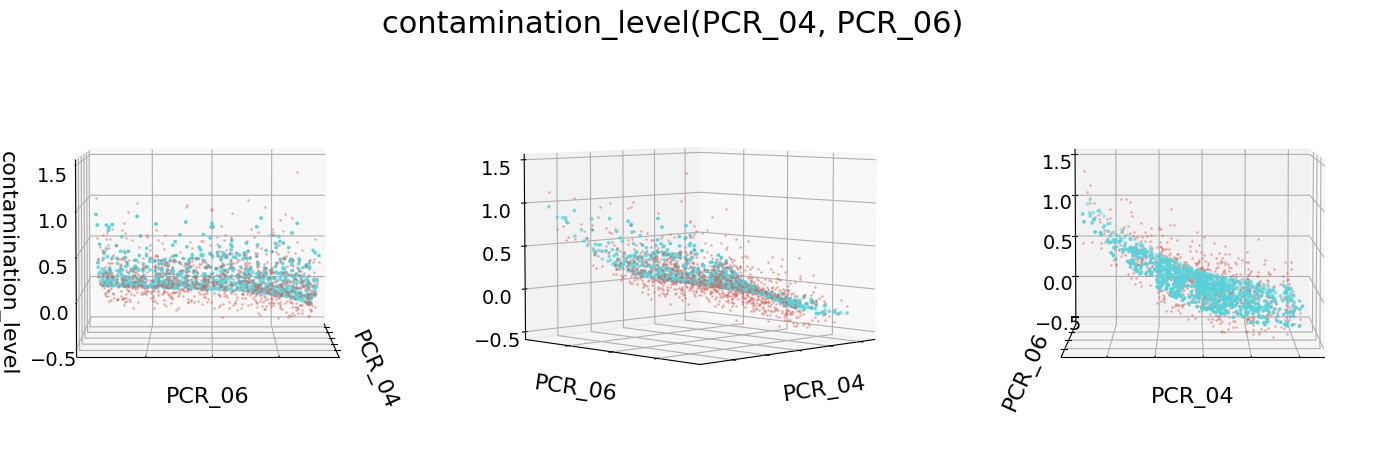

In [53]:
predictions = polynomial_lasso_section_6.predict(X_train[['PCR_04', 'PCR_06']])
plot3d(training_dataset, 'PCR_04', 'PCR_06', 'contamination_level', 'contamination_level(PCR_04, PCR_06)', predictions)

##Q17

In [44]:
# Retrain a lasso regressor on the entire training set according the the best alpha
polynomial_lasso = Pipeline([('feature_mapping', PolynomialFeatures(4)),
                                   ('normalization', MinMaxScaler()),
                                   ('Lasso', Lasso(alpha=best_alpha, fit_intercept=True))])
polynomial_lasso.fit(X_train[['PCR_04', 'PCR_06']], Y_train)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=4)),
                ('normalization', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.00025514065200312873))])

##Q18

In [31]:
# create the desired columns
relevant_features = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04',
                     'PCR_05', 'PCR_06', 'PCR_09', 'PCR_10', 'sugar_levels']

# create the new training set and the appropriate labels
X_train_gbm = training_dataset[relevant_features].copy()
Y_train_gbm = training_dataset['contamination_level'].copy()



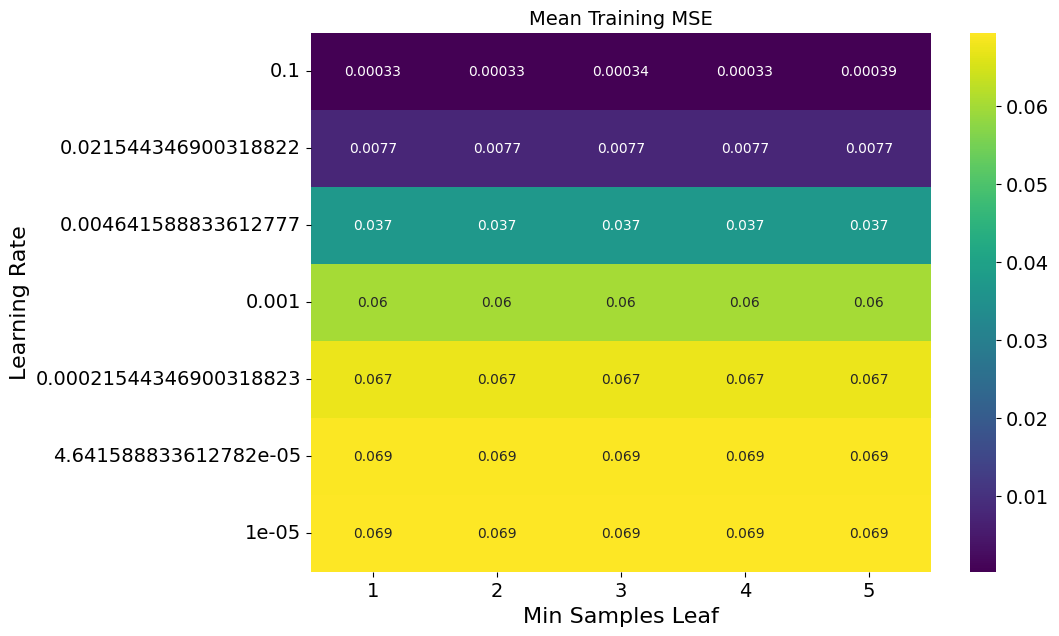

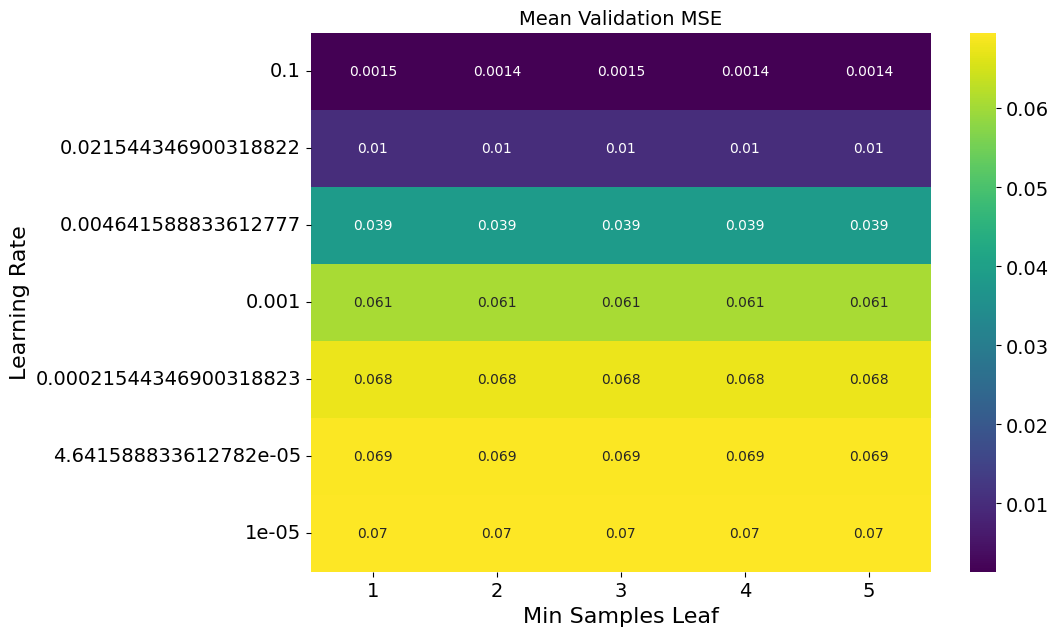

Optimal Parameters after inversion: {'regressor__learning_rate': 0.1, 'regressor__min_samples_leaf': 4}
Best Training MSE:  0.000334647729114145
Best Validation MSE:  0.0013590101986925198


In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gradient_regressor = GradientBoostingRegressor(loss='huber', random_state=95)
pipeline = Pipeline([
    ('normalization', StandardScaler()),
    ('regressor', gradient_regressor)
])

# Define parameter grid
param_grid = {
    'regressor__learning_rate': np.logspace(-5, -1, 7),
    'regressor__min_samples_leaf':  range(1,6)
}


# perform the Grid searching for finding the best combination of hyperparameters 'lr' and 'min_samples_leaf'
gridSearcher = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
gridSearcher.fit(X_train_gbm, Y_train_gbm)

# Extract the cross-validation results into a DataFrame
results = pd.DataFrame(gridSearcher.cv_results_)

# Invert the signs of the mean_test_score and mean_train_score (since they are negative MSE values)
results['inverted_test_score'] = -results['mean_test_score']
results['inverted_train_score'] = -results['mean_train_score']

# Recalculate the best parameters based on the inverted test scores
best_index = results['inverted_test_score'].idxmin()
best_params = results.loc[best_index, 'params']
best_train_error = results['inverted_train_score'][best_index]
best_test_error = results['inverted_test_score'][best_index]

# Create the heatmap with training scores
heatmap_data = results.pivot(index='param_regressor__learning_rate',
                                      columns='param_regressor__min_samples_leaf',
                                      values='inverted_train_score')

# Plot the heatmap
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='viridis')
heatmap.invert_yaxis()
plt.title('Mean Training MSE', fontsize=14)
plt.ylabel('Learning Rate')
plt.xlabel('Min Samples Leaf')
plt.show()

# Create the heatmap with testing scores
heatmap_data = results.pivot(index='param_regressor__learning_rate',
                                      columns='param_regressor__min_samples_leaf',
                                      values='inverted_test_score')

# Plot the heatmap
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='viridis')
heatmap.invert_yaxis()
plt.title('Mean Validation MSE', fontsize=14)
plt.ylabel('Learning Rate')
plt.xlabel('Min Samples Leaf')
plt.show()

# Print the optimal parameters and errors based on the inverted scores
print("Optimal Parameters after inversion:", best_params)
print("Best Training MSE: ", best_train_error)
print("Best Validation MSE: ", best_test_error)






In [48]:
from sklearn.ensemble import GradientBoostingRegressor

# fit the GradientBoostingRegressor model with the best params
gradient_regressor_section_6 = GradientBoostingRegressor(loss='huber', learning_rate=best_params['regressor__learning_rate'], min_samples_leaf=best_params['regressor__min_samples_leaf'])
gradient_regressor_section_6.fit(X_train_gbm, Y_train_gbm)

GradientBoostingRegressor(loss='huber', min_samples_leaf=4)

##Q20

In [54]:
from sklearn.metrics import mean_squared_error

# Evaluate the Dummy model on the test set
X = test_dataset[pcr_columns]
y = test_dataset['contamination_level']
dummy_predictions = dummyRegressor_section_6.predict(X)
dummy_test_mse = mean_squared_error(y, dummy_predictions)

# Evaluate the Linear model on the test set
linear_predictions = linearRegressor_section_6.predict(X)
linear_test_mse = mean_squared_error(y, linear_predictions)

# Evaluate the Lasso model on the test set
lasso_predictions = lassoRegressor_section_6.predict(X)
lasso_test_mse = mean_squared_error(y, lasso_predictions)


# Evaluate the Polynomial Lasso model on the test set
X = test_dataset[['PCR_04', 'PCR_06']]
poly_lasso_predictions = polynomial_lasso_section_6.predict(X)
poly_lasso_test_mse = mean_squared_error(y, poly_lasso_predictions)


# Evaluate the gradient model on the test set
X = test_dataset[relevant_features]
gradient_regressor_predictions = gradient_regressor_section_6.predict(X)
gbm_test_mse = mean_squared_error(y, gradient_regressor_predictions)



# Print the test MSE for each model
print(f"Dummy Test MSE: {dummy_test_mse:.4f}")
print(f"Linear Test MSE: {linear_test_mse:.4f}")
print(f"Lasso Test MSE: {lasso_test_mse:.4f}")
print(f"Polynomial Lasso Test MSE: {poly_lasso_test_mse:.4f}")
print(f"GBM Test MSE: {gbm_test_mse:.4f}")

Dummy Test MSE: 0.0694
Linear Test MSE: 0.0302
Lasso Test MSE: 0.0301
Polynomial Lasso Test MSE: 0.0326
GBM Test MSE: 0.0015
